# Анализ цепей

## Общая информация

Основная идея PySpice заключается в том, что при помощи Python можно описывать цепи на языке SPICE и потом скармливать их непосредственно симулятору.

Алгоритм анализа таков:
- создаём объект цепи `Circuit`, где описываем цепь
- указываем вид симуляции
- симулируем и анализируем результат при помощи `mathplotlib` и `numpy`

PySpice под капотом использует SPICE симуляторы. Для того, чтобы указать, какой симулятор использовать необходимо выставить `PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR`. В данном примере используется `ngspice`, для работы с ним есть два способа:
- использовать динамическую библиотеку `libngspice` (`ngspice-shared`)
- использовать сам симулятор `ngspice` (`ngspice-subprocess`), используется по-умолчанию

Есть замечание насчёт библиотеки: библиотека должна иметь имя `libngspice{}.so`. В Debian системе при установке библиотеки при помощи `apt` она будет иметь имя `libngspice.so.0`. Для решения этой проблемы можно либо сделать символичную ссылку с именем `libngspice.so` где-то в пути поиска библиотек (PySpice ищет библиотеку при помощи `ctypes.util.find_library()`, также можно указать путь к директории при помощи `LD_LIBRARY_PATH`), которая будет указывать на библиотеку, либо указать полный путь к библиотеке в `PySpice.Spice.NgSpice.Shared.NgSpiceShared.NGSPICE_PATH`.

## Подготовка

Перед тем, как приступать к анализу необходимо сконфигурировать окружение.

Настроим логирование:

In [1]:
import PySpice.Logging.Logging as Logging

logger = Logging.setup_logging()

Нужно удостовериться, что выставлен деволтный симулятор во избежания каких-либо ошибок. Иногда код ниже выбрасывает что-то вроде `PySpice has not Spice object`, из-за этого при создании объекта симуляции можно выскакивать ошибка `Expected label Circuit instead of No compability mode`. Сказать бы честно не знаю как это починить и почему возникает эта ошибка, но один из вариантов, который у меня работает это прогнать все ячейки даже если там будут какие-либо ошибки и после этого прогнать эту ячейку.

In [21]:
import PySpice

PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = "ngspice-shared"

Импортируем необходимые объекты для PySpice:

In [3]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

Импортируем объекты для создания графиков mathplotlib:

In [4]:
import matplotlib.pyplot as plt
import numpy as np

Импортируем объекты для рисования схем:

In [5]:
import schemdraw
import schemdraw.elements as elm

Симуляция должна происходит в определённом окружении. Определим глобально температуру:

In [6]:
TEMPERATURE = 25
NOMINAL_TEMPERATURE = 25

## Резистивный делитель напряжения

Будем анализировать самый простой резистивный делитель. Схема представлена ниже:

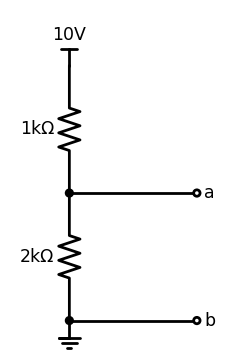

In [30]:
with schemdraw.Drawing() as schematics:
    schematics.add(elm.Vdd().label("10V"))
    schematics.add(elm.Resistor().label("1kΩ").down())
    schematics.add(elm.Dot())
    schematics.push()
    schematics.add(elm.Line().dot(open=True).right().label("a", "right"))
    schematics.pop()
    schematics.add(elm.Resistor().label("2kΩ").down())
    schematics.add(elm.Dot())
    schematics.push()
    schematics.add(elm.Line().dot(open=True).right().label("b", "right"))
    schematics.pop()
    schematics.add(elm.Ground())

Прежде чем приступать к симуляции следует провести необходимые вычисления, чтобы быть понять являются ли результаты симуляции правильными. В данном примере меня интересует разница потенциалов между точкой a и точкой b, для этого нужно использовать формулу делителя напряжения:

$$
V_{ab} = V_{in}\frac{R2}{R1 + R2} = 12\text{V}\frac{2k\text{Ohm}}{1k\text{Ohm} + 2k\text{Ohm}} = 12\frac{2000}{3000} = 6.67\text{V}
$$

### DC анализ

Проанализируем DC цепь на примере резистивного делителя напряжения.

Создадим новый объект, где будет описывать саму цепь:

In [8]:
circuit = Circuit("Resistive Voltage Divider")

Добавим все елементы цепи:

In [9]:
circuit.V(1, "in", circuit.gnd, 10@u_V)
circuit.R(1, "in", "out", 1@u_kOhm)
circuit.R(2, "out", circuit.gnd, 2@u_kOhm)

2023-01-30 14:16:40,152 - PySpice.Spice.Netlist.Node.__init__ - WARNING - Node name 'in' is a Python keyword


Resistor R2

Важно запомнить названия узлов так как далее при анализе результатов именно при помощи этих имён мы сможет определить где находиться узел.

PySpice сформировал SPICE код, может его посмотреть:

In [10]:
print(circuit)

.title Resistive Voltage Divider
V1 in 0 10V
R1 in out 1kOhm
R2 out 0 2kOhm



Создадим объект симуляции:

In [11]:
simulator = circuit.simulator(temperature=TEMPERATURE, nominal_temperature=TEMPERATURE)
print(simulator)

2023-01-30 14:16:43,117 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._init_ngspice - WARNING - Unsupported Ngspice version 38
.title Resistive Voltage Divider
V1 in 0 10V
R1 in out 1kOhm
R2 out 0 2kOhm
.options TEMP = 25C
.options TNOM = 25C
.end



Меня интересует напряжение.

In [12]:
analysis = simulator.operating_point()

Выведем названия узлов и значения напряжения, которое впадает в этот узел:

In [13]:
for node in analysis.nodes.values():
    print(f"Node {str(node)}: {float(node):.2f}V")

Node out: 6.67V
Node in: 10.00V


Хотелось бы в который раз удостовериться, что чем выше входное напряжение делителя тем выше выходное. Для этого анализа узлов мало, необходимо как-то изменять входное напряжение. Для этого можно использовать DC анализ:

In [14]:
analysis = simulator.dc(V1=slice(0.0, 5.0, 0.01))

Остаётся только сформировать график зависимости входного напряжения от выходного:

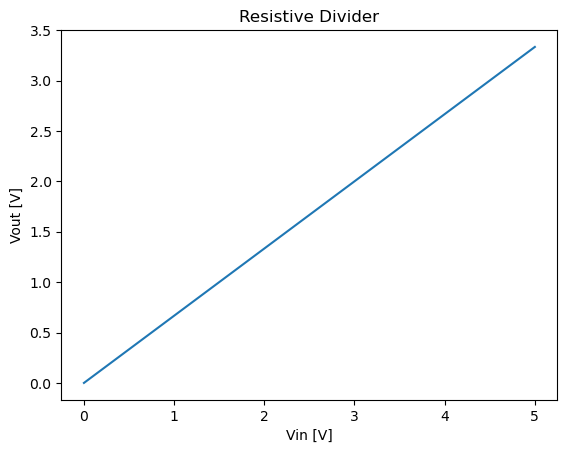

In [15]:
plt.plot(np.array(analysis.nodes["in"]), np.array(analysis.nodes["out"]))
plt.title("Resistive Divider")
plt.xlabel("Vin [V]")
plt.ylabel("Vout [V]")
plt.show()

### AC анализ

Аналогично проанализируем резистивный делитель переменного напряжения.

In [16]:
circuit = Circuit("Resistive AC Voltage Divider")

In [17]:
circuit.SinusoidalVoltageSource(1, "in", circuit.gnd, amplitude=10@u_V, frequency=5@u_Hz)
circuit.R(1, "in", "out", 1@u_kOhm)
circuit.R(2, "out", circuit.gnd, 2@u_kOhm)

2023-01-30 14:16:46,956 - PySpice.Spice.Netlist.Node.__init__ - WARNING - Node name 'in' is a Python keyword


Resistor R2

In [18]:
print(circuit)

.title Resistive AC Voltage Divider
V1 in 0 DC 0V AC 1V SIN(0V 10V 5Hz 0s 0Hz)
R1 in out 1kOhm
R2 out 0 2kOhm



In [19]:
simulation = circuit.simulator(temperature=TEMPERATURE, nominal_temperature=TEMPERATURE)
analysis = simulation.transient(step_time=1@u_ms, end_time=1@u_s)

Out amplitude: 6.666408742668121


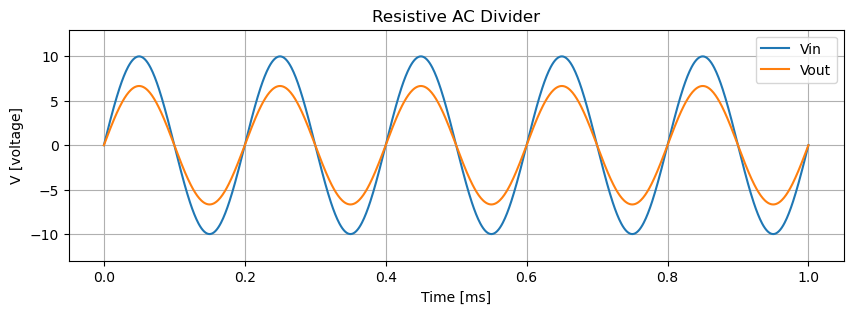

In [20]:
in_ = np.array(analysis.nodes["in"])
out = np.array(analysis.nodes["out"])

figure, axis = plt.subplots(figsize=(10, 3))
axis.set_title("Resistive AC Divider")
axis.set_xlabel("Time [ms]")
axis.set_xticks(np.arange(0.0, 1.1, 0.2))
axis.set_ylabel("V [voltage]")
axis.set_ylim(-13, 13)
axis.plot(np.array(analysis.time), in_, label="Vin")
axis.plot(np.array(analysis.time), out, label="Vout")
axis.grid(True)
axis.legend()
print("Out amplitude: " + str(np.max(np.array(analysis.nodes["out"]))))